# Descriptive Statistics and Tests - Introduction


## Test for Stationarity: Augmented Dickey-Fuller Test

Performs a test in the form of null hypothesis and returns a p value.

- Null hypothesis: $\phi=1$

- If p value below set alpha (0.05), then reject the null hypothesis, i.e., the time series is considered stationary.

- If p value is high, then we fail to reject and time series can be considered non-stationary

## Granger Causality Test

Also a hypothesis test. Determines if one time series is useful in forecasting another.

Correlation between time series is easy to measure (one goes up, other goes up). One time series changes causes another time series to change in the future is a completely different beast. Granger Causality can help here. However, even if there is strong causality reported, there could still be a third party factor that has causality on both, so it is in reality some outside factor and not the time series that affects the other time series! What can help here is subject matter expertise.

## AIC Akaike Information Criterion

AIC evaluates a collection of models and estimates the quality of each model relative to the others. Penalties are provided for the number of parameters used in an effort to thwart overfitting.

Rather have a simpler model that performs slightly less over a more complex model that is only miniscule better than the simpler model.

## BIC Bayesian Information Criterion

Similar to AIC but uses Bayesian mathematics.

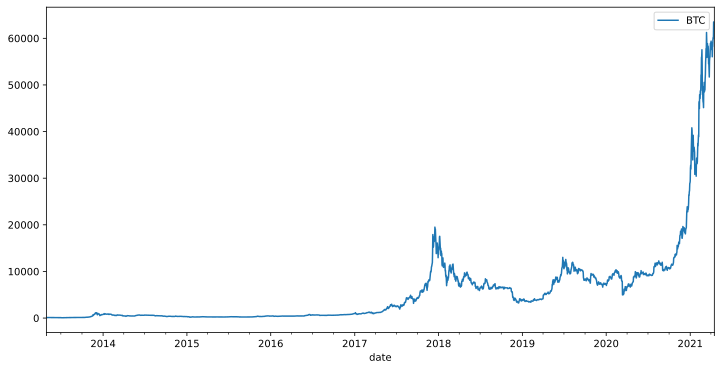

In [30]:
import os
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from IPython.display import set_matplotlib_formats
import seaborn as sns
from statsmodels.tsa.filters.hp_filter import hpfilter
set_matplotlib_formats('svg')

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

folder = f'../02.Prepared_data/2021-04-18/'

def load_coins(folder):
#     folder = f'../02.Prepared_data/2021-04-05/'
    
    BTC = pd.read_csv(f"{folder}/BTC_Bitcoin.csv", index_col=0, parse_dates=['date'])
    ETH = pd.read_csv(f"{folder}/ETH_Ethereum.csv", index_col=0, parse_dates=['date'])
    XMR = pd.read_csv(f"{folder}/XMR_Monero.csv", index_col=0, parse_dates=['date'])
    DASH = pd.read_csv(f"{folder}/DASH_Dash.csv", index_col=0, parse_dates=['date'])
    LTC = pd.read_csv(f"{folder}/LTC_Litecoin.csv", index_col=0, parse_dates=['date'])
    XRP = pd.read_csv(f"{folder}/XRP_XRP.csv", index_col=0, parse_dates=['date'])
    ADA = pd.read_csv(f"{folder}/ADA_Cardano.csv", index_col=0, parse_dates=['date'])
    DOT = pd.read_csv(f"{folder}/DOT_Polkadot.csv", index_col=0, parse_dates=['date'])

    coins = [ETH, XMR, DASH, LTC, XRP, ADA, DOT]
    # make sure that all have date as index
    new_coins = []
    for df in coins:
        df = df.sort_values(by='date')
        df = df.drop_duplicates(subset='date', keep='first')
        df = df.set_index('date', drop=True)
        df = df.asfreq('D', method='ffill')
        new_coins.append(df)

    BTC = BTC.sort_values(by='date')
    BTC = BTC.drop_duplicates(subset='date', keep='first')
    BTC = BTC.set_index('date', drop=True)
    BTC = BTC.asfreq('D', method='ffill')
    coins = [BTC] + new_coins

    cols = ['BTC', 'ETH', 'XMR', 'DASH', 'LTC', 'XRP', 'ADA', 'DOT']
    df = pd.DataFrame()

    for col, coin in zip(cols, coins):
        vals = coin['close'].asfreq('D', method='ffill') # in case there were some skipped days
        df[col] = vals
        
    return df


coins = load_coins(folder)
BTC = pd.DataFrame()
BTC['BTC'] = coins['BTC']

BTC.loc[:].plot(figsize=(12,6))
BTC.head()

path = '../01.Original_data/time_series_course_Data/'
data_passengers = pd.read_csv(f"{path}airline_passengers.csv", parse_dates=True, index_col=0)
data_passengers.index.freq = 'MS'
data_births = pd.read_csv(f"{path}daily_female_births.csv", parse_dates=True, index_col=0)
data_births.index.freq = 'D'

data_samples = pd.read_csv(f"{path}samples.csv", parse_dates=True, index_col=0)
data_samples.index.freq = 'MS'

# Augmented Dickey-Fuller Test

In [15]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [5]:
adfuller(data_passengers['Thousands of Passengers'])

(0.8153688792060472,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.6929308390189)

In [7]:
help(adfuller)

Help on function adfuller in module statsmodels.tsa.stattools:

adfuller(x, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)
    Augmented Dickey-Fuller unit root test.
    
    The Augmented Dickey-Fuller test can be used to test for a unit root in a
    univariate process in the presence of serial correlation.
    
    Parameters
    ----------
    x : array_like, 1d
        The data series to test.
    maxlag : int
        Maximum lag which is included in test, default 12*(nobs/100)^{1/4}.
    regression : {"c","ct","ctt","nc"}
        Constant and trend order to include in regression.
    
        * "c" : constant only (default).
        * "ct" : constant and trend.
        * "ctt" : constant, and linear and quadratic trend.
        * "nc" : no constant, no trend.
    
    autolag : {"AIC", "BIC", "t-stat", None}
        Method to use when automatically determining the lag length among the
        values 0, 1, ..., maxlag.
    
        * If "AIC" (default)

## Passenger data

<AxesSubplot:xlabel='Month'>

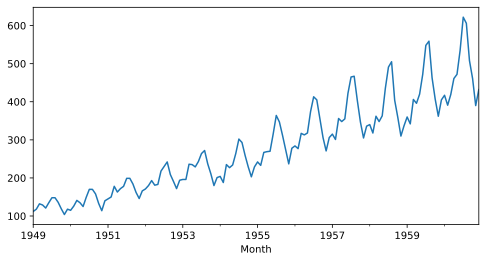

In [24]:
data_passengers['Thousands of Passengers'].plot(figsize=(8,4))

In [25]:
dftest = adfuller(data_passengers['Thousands of Passengers'])
dfout = pd.Series(dftest[0:4], index=['ADF Test Statistic', 'p-value', 'Number of lags used', 'Number of observations'])
for key, val in dftest[4].items():
    dfout[f'critical value ({key})'] = val
dfout

ADF Test Statistic          0.815369
p-value                     0.991880
Number of lags used        13.000000
Number of observations    130.000000
critical value (1%)        -3.481682
critical value (5%)        -2.884042
critical value (10%)       -2.578770
dtype: float64

## Bitcoin

<AxesSubplot:xlabel='date'>

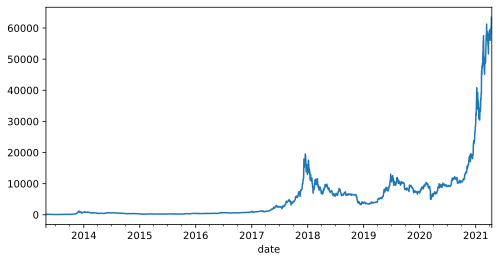

In [26]:
BTC["BTC"].plot(figsize=(8,4))

In [27]:
adf_test(BTC["BTC"],title='Bitcoin')

Augmented Dickey-Fuller Test: Bitcoin
ADF test statistic         6.092507
p-value                    1.000000
# lags used               24.000000
# observations          2885.000000
critical value (1%)       -3.432619
critical value (5%)       -2.862542
critical value (10%)      -2.567304
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


## Births

<AxesSubplot:xlabel='Date'>

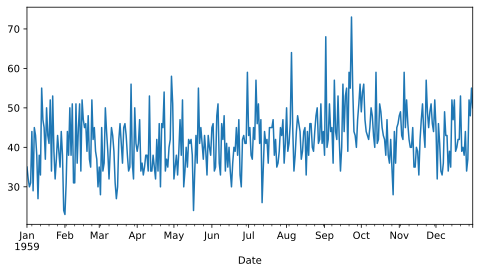

In [28]:
data_births['Births'].plot(figsize=(8,4))

In [29]:
adf_test(data_births['Births'],title='Births')

Augmented Dickey-Fuller Test: Births
ADF test statistic       -4.808291
p-value                   0.000052
# lags used               6.000000
# observations          358.000000
critical value (1%)      -3.448749
critical value (5%)      -2.869647
critical value (10%)     -2.571089
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


The Birth dataset is difficult to tell from the naked eye if it is stationary or not!

# Granger Causality Test

In [32]:
data_samples # this is made up data

,a,b,c,d
1950-01-01,36,27,0,67
1950-02-01,58,22,3,31
1950-03-01,61,17,5,67
1950-04-01,37,15,8,47
1950-05-01,66,13,8,62
...,...,...,...,...
1959-08-01,49,73,9338,58
1959-09-01,41,77,9502,38
1959-10-01,64,70,9667,42
1959-11-01,37,87,9833,62


<AxesSubplot:>

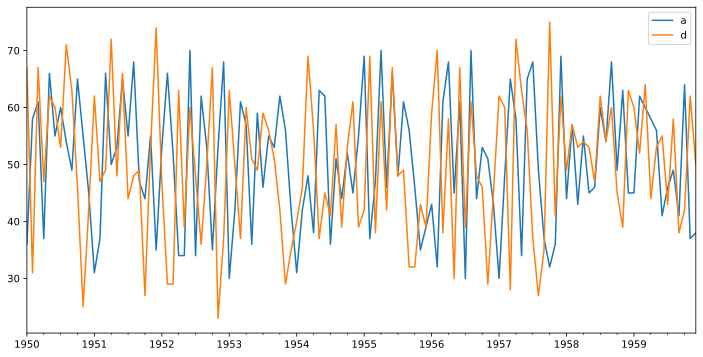

In [33]:
data_samples[['a', 'd']].plot(figsize=(12,6))

It is hard to tell if there is a causality between `a` and `d`.

<AxesSubplot:>

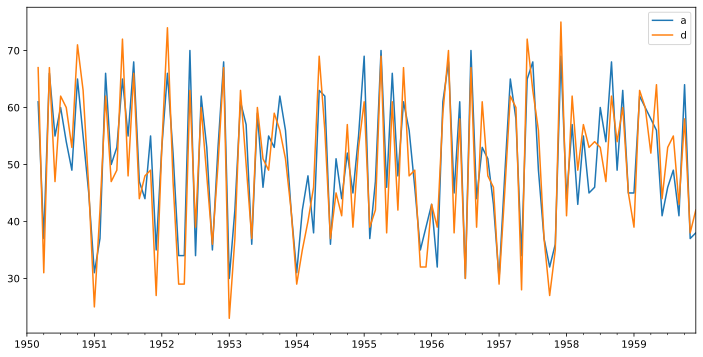

In [48]:
data_samples['a'].iloc[2:].plot(figsize=(12,6), legend=True)
data_samples['d'].shift(2).plot(legend=True)

Now the two series align pretty well. So this means that two days after there is some change in `d`, `a` is reflecting this. Hence, there is some causality between the two series. It is extremely unlikely that one will guess this from looking at the original, unshifted dataset! That is where Granger Causality test can help.

In [38]:
from statsmodels.tsa.stattools import grangercausalitytests

In [51]:
grangercausalitytests(data_samples[['a','d']], maxlag=3);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=1.7492  , p=0.1860  , df=1
likelihood ratio test: chi2=1.7365  , p=0.1876  , df=1
parameter F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=597.3806, p=0.0000  , df=2
likelihood ratio test: chi2=212.6514, p=0.0000  , df=2
parameter F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=188.7446, p=0.0000  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=602.2669, p=0.0000  , df=3
likelihood ratio test: chi2=212.4789, p=0.0000  , df=3
parameter F test:         F=188.7446, p=0.0000  , df_denom=110, df_num=3


There is causality between `a` and `d` for lags greater 2.

This can be a good starting point for future analysis, the Granger Causality test does not give further information than this, domain knowledge will be required for that.

In [46]:
grangercausalitytests(data_samples[['b','d']], maxlag=3);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5225  , p=0.2197  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=1.5619  , p=0.2114  , df=1
likelihood ratio test: chi2=1.5517  , p=0.2129  , df=1
parameter F test:         F=1.5225  , p=0.2197  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4350  , p=0.6483  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=0.9086  , p=0.6349  , df=2
likelihood ratio test: chi2=0.9051  , p=0.6360  , df=2
parameter F test:         F=0.4350  , p=0.6483  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5333  , p=0.6604  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=1.7018  , p=0.6365  , df=3
likelihood ratio test: chi2=1.6895  , p=0.6393  , df=3
parameter F test:         F=0.5333  , p=0.6604  , df_denom=110, df_num=3


We see that there seems to be no causality, because of high p-values.

# Evaluating forecast accuracy
Two calculations related to linear regression are <a href='https://en.wikipedia.org/wiki/Mean_squared_error'><strong>mean squared error</strong></a> (MSE) and <a href='https://en.wikipedia.org/wiki/Root-mean-square_deviation'><strong>root mean squared error</strong></a> (RMSE)

The formula for the mean squared error is<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;$MSE = {\frac 1 L} \sum\limits_{l=1}^L (y_{T+l} - \hat y_{T+l})^2$<br><br>
where $T$ is the last observation period and $l$ is the lag point up to $L$ number of test observations.

The formula for the root mean squared error is<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;$RMSE = \sqrt{MSE} = \sqrt{{\frac 1 L} \sum\limits_{l=1}^L (y_{T+l} - \hat y_{T+l})^2}$<br><br>

The advantage of the RMSE is that it is expressed in the same units as the data.<br><br>

A method similar to the RMSE is the <a href='https://en.wikipedia.org/wiki/Mean_absolute_error'><strong>mean absolute error</strong></a> (MAE) which is the mean of the magnitudes of the error, given as<br><br>

&nbsp;&nbsp;&nbsp;&nbsp;$MAE = {\frac 1 L} \sum\limits_{l=1}^L \mid{y_{T+l}} - \hat y_{T+l}\mid$<br><br>

A forecast method that minimizes the MAE will lead to forecasts of the median, while minimizing the RMSE will lead to forecasts of the mean.

In [54]:
np.random.seed(42)

df = pd.DataFrame(np.random.randint(20,30,(50,2)), columns=['test', 'predictions'])
df.head()

,test,predictions
0,26,23
1,27,24
2,26,29
3,22,26
4,27,24


<AxesSubplot:>

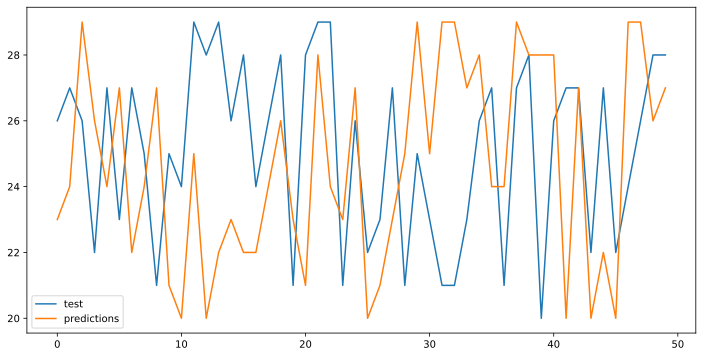

In [56]:
df.plot(figsize=(12,6))

In [57]:
from statsmodels.tools.eval_measures import mse,rmse,meanabs

In [58]:
mse(df['test'], df['predictions'])

17.02

In [59]:
meanabs(df['test'], df['predictions'])

3.54

In [61]:
rmse(df['test'], df['predictions'])

4.125530268947253

In [62]:
MSE = mse(df['test'],df['predictions'])
RMSE = rmse(df['test'],df['predictions'])
MAE = meanabs(df['test'],df['predictions'])

print(f'Model  MSE: {MSE:.3f}')
print(f'Model RMSE: {RMSE:.3f}')
print(f'Model  MAE: {MAE:.3f}')

Model  MSE: 17.020
Model RMSE: 4.126
Model  MAE: 3.540


<AxesSubplot:xlabel='Month'>

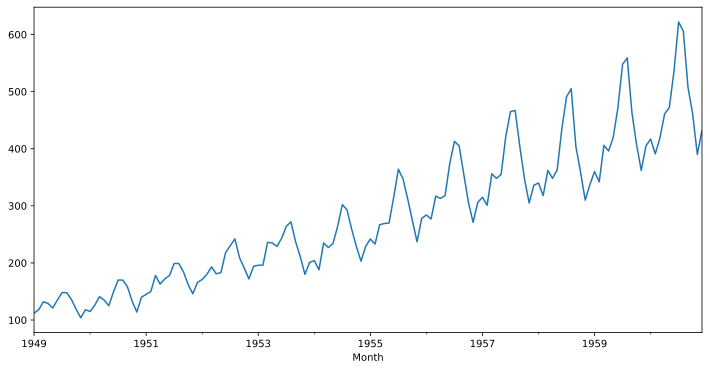

In [63]:
data_passengers['Thousands of Passengers'].plot(figsize=(12,6))

In [64]:
from statsmodels.graphics.tsaplots import month_plot, quarter_plot

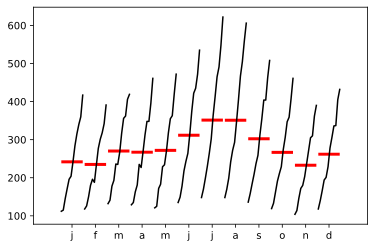

In [65]:
month_plot(data_passengers['Thousands of Passengers']);

Takes in range of values and their average. We can see there is an uptick during the summer months.

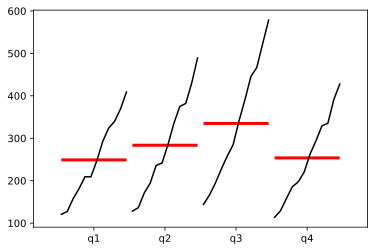

In [66]:
data_passengers_quarterly = data_passengers['Thousands of Passengers'].resample(rule='Q').mean()
quarter_plot(data_passengers_quarterly);

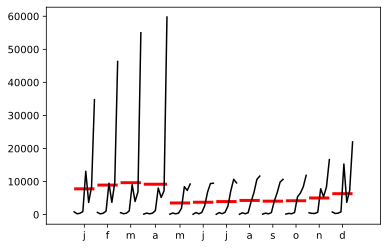

In [84]:
BTC_month = BTC[['BTC']].resample(rule='M').mean() 
month_plot(BTC_month);

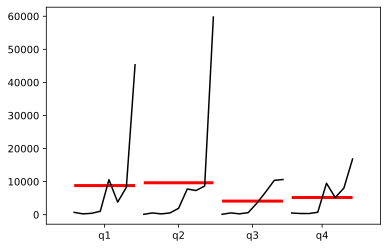

In [72]:
BTC_q = BTC['BTC'].resample(rule='Q').mean()
quarter_plot(BTC_q);